# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.



In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
%matplotlib inline

In [ ]:
# cargar base heartDisease.  pd.read_csv()
heart_df=pd.read_csv("heartDisease/framingham.csv")

# dropna(axis=0 filas, inplace=True),  dropear filas con observaciones NA
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

In [ ]:

# numero de observaciones 
print(f'Se tienen {len(heart_df)} datos.')

### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

In [ ]:
# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [ ]:
# establecer x variables, y observación(variable) a predecir
x = heart_df.iloc[:,:-1]
y = heart_df.iloc[:,-1]

# dividir train-set y test-set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=22)
x_train

In [ ]:
# crear escalador MinMaxScaler() sobre los predictores X para train-set y test-set
scaler = MinMaxScaler() # Utilice un MinMaxScaler #
x_train = scaler.fit_transform(x_train) # Aplique el Escalamiento (función fit_transform) # 
x_test =  scaler.fit_transform(x_test) # Aplique el Escalamiento (función fit_transform) #

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [ ]:
# crear modelo de regresion logistica
logreg = LogisticRegression()# Modelo de Regresión Logística #

# fit/train  ajustar el modelo para encontrar los Bi estimadores
logreg.fit(x_train, y_train) # Entrenamiento sobre los Datos #

# obtener las predicciones de clase
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #

print(f'Precisión inicial: {logreg.score(x_test, y_test)}')


### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.



Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

## Matriz de Confusión: metricas de evaluación en clasificación


#accuracy(score)= (TP+TN)/TOT: ratio de predicciones correctas vs. totales

#recall= TP/(TP+FN): ratio de predicciones correctas de clases positivas
#recall is a good measure to determine, when high cost associated with False Negative.

#precision/sensibilidad= TP/(TP+FP): ratio de TP vs. los totales positivos, cuantos predecidos positivos son realmente positivos
#precision is a good measure to determine, when the costs of False Positive is high

#F-measure: (2*recall*precision)/(recall+precision): medición de precision(acc) y recall al mismo tiempo, penaliza los valores extremos
#F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND 
#there is an uneven class distribution (large number of Actual Negatives).

#confusion_matrix(y_test,y_pred): la matriz de confusión se calcula entre
#las observaciones del test-set yi y el vector de prediciones yi^

In [ ]:
# crear matriz de confusión: métricas de evaluacion en clasificación 
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [ ]:

    
#print(y_pred_prob_yes[4])
#print(x_test)
cm2

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [ ]:
from sklearn.preprocessing import binarize

# crear vector(array) que tiene el umbral de probabilidad para definir la pertenencia de clase
umbrales = np.linspace(0,1,20) #Vector que Contiene los Umbrales a Analizar #

# itera sobre los umbrales
for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)# Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    
    # convierte el vector de probabilidades de pertenencia, a clases 0 y 1 
    y_pred2 = binarize(y_pred_prob_yes, threshold= umbral)# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    
    # crear matriz de confusión
    cm2 = confusion_matrix(y_test,y_pred2[:,1])
    
    # métricas de evaluación en función del umbral de probabilidad de pertenencia
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos positivos.
Sensitividad/Recall: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n''')

umbrales

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

*Se quiere maximizar el area bajo la curva. para esta aplicación se quiere maximizar la tasa de TP (sensitividad/recall) a costo de precisión(acc) o tasa de FP

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [3]:
# cargar base heartDisease.  pd.read_csv()
heart_df=pd.read_csv("heartDisease/framingham.csv")

# limpiar  la base - data mining
# dropna(axis=0 filas, inplace=True),  dropear filas con observaciones NA
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

# dummyficar la base: crear variables dicotomas 0-1 para todas las variables categoricas
# ** para esta base todas las variables son continuas, entonces no hay variables discretas(categoricas) que dummyficar 
heart_df_dumm = pd.get_dummies(heart_df, drop_first=True)

# crear escalador Robusto
scaler = RobustScaler() # Escalador Robusto de X (train-set y test-set) #

# ***escalar toda la base con el escalador RobustScaler() 
df_scaled = scaler.fit_transform(heart_df_dumm)
df_scaled = pd.DataFrame(df_scaled, columns = heart_df_dumm.columns)

df_scaled

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,-0.714286,0.0,0.00,0.0,0.0,0.0,0.0,-0.672414,-0.814815,-0.800000,0.313883,0.357143,-0.0625,0.0
1,0.0,-0.214286,0.0,0.00,0.0,0.0,0.0,0.0,0.275862,-0.259259,-0.066667,0.668008,1.428571,-0.1250,0.0
2,1.0,-0.071429,1.0,1.00,0.0,0.0,0.0,0.0,0.189655,-0.018519,-0.133333,-0.014085,0.000000,-0.5000,0.0
3,0.0,0.857143,1.0,1.50,0.0,0.0,1.0,0.0,-0.155172,0.814815,0.866667,0.637827,-0.714286,1.5625,1.0
4,0.0,-0.214286,1.0,1.15,0.0,0.0,0.0,0.0,0.879310,0.074074,0.133333,-0.464789,0.714286,0.4375,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3744,1.0,0.642857,0.0,0.00,0.0,0.0,1.0,0.0,-0.810345,0.481481,-0.066667,-0.090543,0.357143,0.1875,0.0
3745,1.0,1.357143,0.0,0.00,0.0,0.0,1.0,0.0,-1.000000,1.481481,1.000000,-0.456740,-1.071429,0.0625,1.0
3746,1.0,0.071429,1.0,0.05,0.0,0.0,1.0,0.0,1.362069,1.888889,0.666667,0.112676,-0.642857,0.5000,1.0
3747,1.0,0.142857,1.0,2.15,0.0,0.0,0.0,0.0,-0.465517,-0.055556,-0.133333,-1.146881,-0.714286,-0.6250,0.0


In [7]:
# establecer x variables, y observación(variable) a predecir
x = df_scaled.drop(['TenYearCHD'], axis=1) # x
y = df_scaled['TenYearCHD'] # y[0-1]: TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro categorica(dicotoma)

# dividir train-set y test-set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=22)


x_train
# crear escalador MinMaxScaler() sobre las observaciones de la base X (los predictores X) para X train-set y  X test-set
#scaler = RobustScaler() # Escalador Robusto de X (train-set y test-set) #
#x_train = scaler.fit_transform(x_train) # Aplique el Escalamiento (función fit_transform) # 
#x_test =  scaler.fit_transform(x_test) # Aplique el Escalamiento (función fit_transform) #

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3391,0.0,0.214286,0.0,0.00,0.0,0.0,0.0,0.0,-0.431034,-0.629630,-0.200000,-0.358149,1.500000,-0.5000
459,1.0,-1.000000,1.0,1.00,0.0,0.0,0.0,0.0,-0.051724,-0.222222,-0.633333,-0.529175,-0.214286,0.9375
1001,1.0,0.357143,1.0,0.45,0.0,0.0,0.0,0.0,0.120690,-1.000000,-0.666667,0.591549,-0.428571,-0.5000
2058,1.0,0.071429,1.0,1.00,0.0,0.0,1.0,0.0,0.465517,1.925926,1.200000,0.098592,1.214286,-0.7500
778,1.0,-0.071429,0.0,0.00,0.0,0.0,0.0,0.0,0.224138,0.111111,-0.200000,-0.661972,0.214286,0.3125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.0,-0.142857,1.0,0.15,0.0,0.0,0.0,0.0,-1.362069,-0.203704,-0.300000,-0.818913,-0.714286,0.0000
3008,1.0,-0.357143,0.0,0.00,0.0,0.0,1.0,0.0,-0.086207,0.518519,0.666667,-0.040241,-0.214286,-0.1250
812,0.0,0.857143,0.0,0.00,0.0,0.0,1.0,0.0,0.431034,1.462963,0.633333,0.828974,2.357143,0.4375
2180,1.0,-1.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.706897,0.166667,-0.200000,1.736419,0.000000,0.1250


In [9]:
# crear seed para replicabilidad   
np.random.seed(22)

# crear el predictor cte=1 
x_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values
x_test_array = np.c_[np.ones(y_test.values.shape[0]), y_test.values]
y_test_array = y_test.values

print(x_train_array.shape)
x_train_array

(2999, 15)


array([[ 1.        ,  0.        ,  0.21428571, ..., -0.35814889,
         1.5       , -0.5       ],
       [ 1.        ,  1.        , -1.        , ..., -0.52917505,
        -0.21428571,  0.9375    ],
       [ 1.        ,  1.        ,  0.35714286, ...,  0.5915493 ,
        -0.42857143, -0.5       ],
       ...,
       [ 1.        ,  0.        ,  0.85714286, ...,  0.82897384,
         2.35714286,  0.4375    ],
       [ 1.        ,  1.        , -1.        , ...,  1.73641851,
         0.        ,  0.125     ],
       [ 1.        ,  1.        , -0.07142857, ..., -0.09255533,
         0.        , -0.0625    ]])

In [51]:
# inicializar w: vector de los estimadores/predictores del modelo
# w0 es el vector de estimadores inicial aleatorio que solo se usa en la primera iteración
w0 = np.random.rand(x_train_array.shape[1]) # Inicialización de w #w = w0.copy()
# w vector de estimadores/predictores que se va a actualizar
w= w0.copy()
w_ant=w0

# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-5 # epsilon que es el umbral del error para asegurar convergencia
error0 = 100 # se inicializa el error
dif = 100 # se inicializa la diferencia de los errores en 100 (default)


# calcular la tasa optima
xtx = np.dot(x_train_array.transpose(), x_train_array)
vp = np.linalg.eigvals(xtx)
max_vp = np.sqrt(max(vp))
tasa0 = (2/max_vp)-0.001


#tasas = [0.001,0.003,0.006]
tasas = np.linspace(0,0.5,200) # Defina un vector que contenga las tasas que desea probar #


errores = [] # agregar los errores a la lista en cada iteración
errores.append(error0)

# numero de iteraciones en las que converge el algoritmo
n = 0

# definir la función de activación: para el caso de regresión logistica
# la función de activación es la función sigmoide
# la función sigmoide(sigma) es la probabilidad dada por el modelo con parámetros w(beta)
# que la observacion xi pertenezca a la clase k (k=1)


# el gradiente es la función sigmoide (probabilida de pertenencia) de xi con parámetros/estimadores wi 

# parámetros: wi predictores/estimadores actuales, xi x actual el punto estocástico
def sigma(w,x):
    wtx=np.dot(w.transpose(),x)
    res_sigmoid = 1/(1+np.exp(-wtx)) # Salida de la función sigmoide #
    return res_sigmoid

# valores de prueba
#dif = 10
#eps=0


# parametros de validacion cruzada

tasa_opt=tasas[0]
n_opt=100000000
dif_min=100


# algoritmo gradiente (descendente??) estocastico
# encontrar el w_opt que maximice la función de max. versimilitud sigma
# ajustar w a w_opt de parámetros/estimadores

for tasa in tasas:
    # while error>eps:         # Criterio de parada 1 #
    #for j in range (0, 1000):  # Criterio de parada 2 #
    while dif > eps:
        # escoger el punto aleatorio
        i = np.random.randint(x_train_array.shape[0])
        xActual = x_train_array[i] #X_train_array[i]
        yActual = y_train_array[i]
        
        # calculo del gradiente, aplicando la funcion logistica
        gradiente_log = sigma(w,xActual)   
        
        # error: yi-y_pred
        error = yActual - gradiente_log
        errores.append(error)
        
        # calcular/actualizar el vector de estimadores/predictores
        w = w_ant-tasa*error*xActual
        
        # calcular la diferencia de errores para comparar con umbral de convergencia eps
        dif = np.abs(errores[-1]-errores[-2]) 
        w_ant = w
        n+=1
        #eps+=1
        
        
        x_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
        y_test_array = y_test.values

        
        # crear vector de y_hat
        y_hat = np.zeros(len(x_test))
        c = 0.5 # umbral de Probabilidad de Bernoulli
        
        # recorre vector y_hat de predicciones
        # predice para la observacion  x_test_array[i] la clase k[0-1]
        # calcula la función sigma de verosimilitud de probabilidad de pertenencia
        for i in range(0, len(x_test)):
            prob_sigma = sigma(w, x_test_array[i])
            if prob_sigma>c:
                y_hat[i]=1
            else:
                y_hat[i]=0
        print(f'Precisión modelo actual: {sklearn.metrics.accuracy_score(y_test,y_hat)}')
    
    
    if dif<dif_min:
        dif_min=dif
        tasa_opt=tasa     
        
        

print("El número de iteraciones en las que convergió el algorimto de Gradiente Descendente Estocástico es: "+str(n)) 
print("La diferencia de errores en la última iteración es: "+ str(dif))
print("El vector de predictores/estimadores que mejor ajusta el modelo para máxima verosimilitud es: " + str(w))


    


Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisión modelo actual: 0.304
Precisió

## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

<AxesSubplot:>

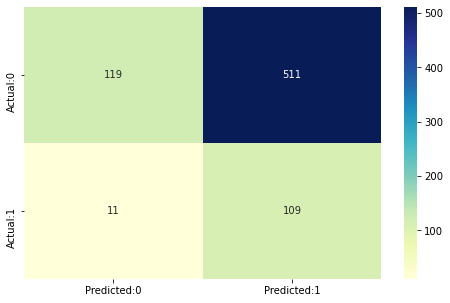

In [53]:
cm = confusion_matrix(y_test,y_hat)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")